# Developing "Anamoly" Feature for Time-Series

In [1]:
from fbprophet import Prophet
from vega_datasets import data
import altair as alt
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
import datetime
import pickle

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing Data

In [3]:
#read in textfile as dataframe with time converted to minutes only (datetime )
with open("ICU_data/132543.txt") as f:
    content = f.readlines()
    contents = [i.rstrip().split(',') for i in content]
data = pd.DataFrame(contents).iloc[1:]

#changing time to datetime object, and all string values to floats
data[0] = pd.to_datetime(['1900-01-0'+str(int(int(row[:2])/24)+1)+' '
                          +str(int(int(row[:2])%24))+':'+row[3:5]+':00' for row in data[0]])
data[2] = [float(row) for row in data[2]]

In [4]:
#Create single feature dataframes for plotting
NISysABP = data[data[1] == 'NISysABP'].drop(columns = 1)
NIDiasABP = data[data[1] == 'NIDiasABP'].drop(columns = 1)
NIMAP = data[data[1] == 'NIMAP'].drop(columns = 1)
SysABP = data[data[1] == 'SysABP'].drop(columns = 1)
DiasABP = data[data[1] == 'DiasABP'].drop(columns = 1)
MAP = data[data[1] == 'MAP'].drop(columns = 1)
Temp = data[data[1] == 'Temp'].drop(columns = 1)
HR = data[data[1] == 'HR'].drop(columns = 1)
Weight = data[data[1] == 'Weight'].drop(columns = 1)

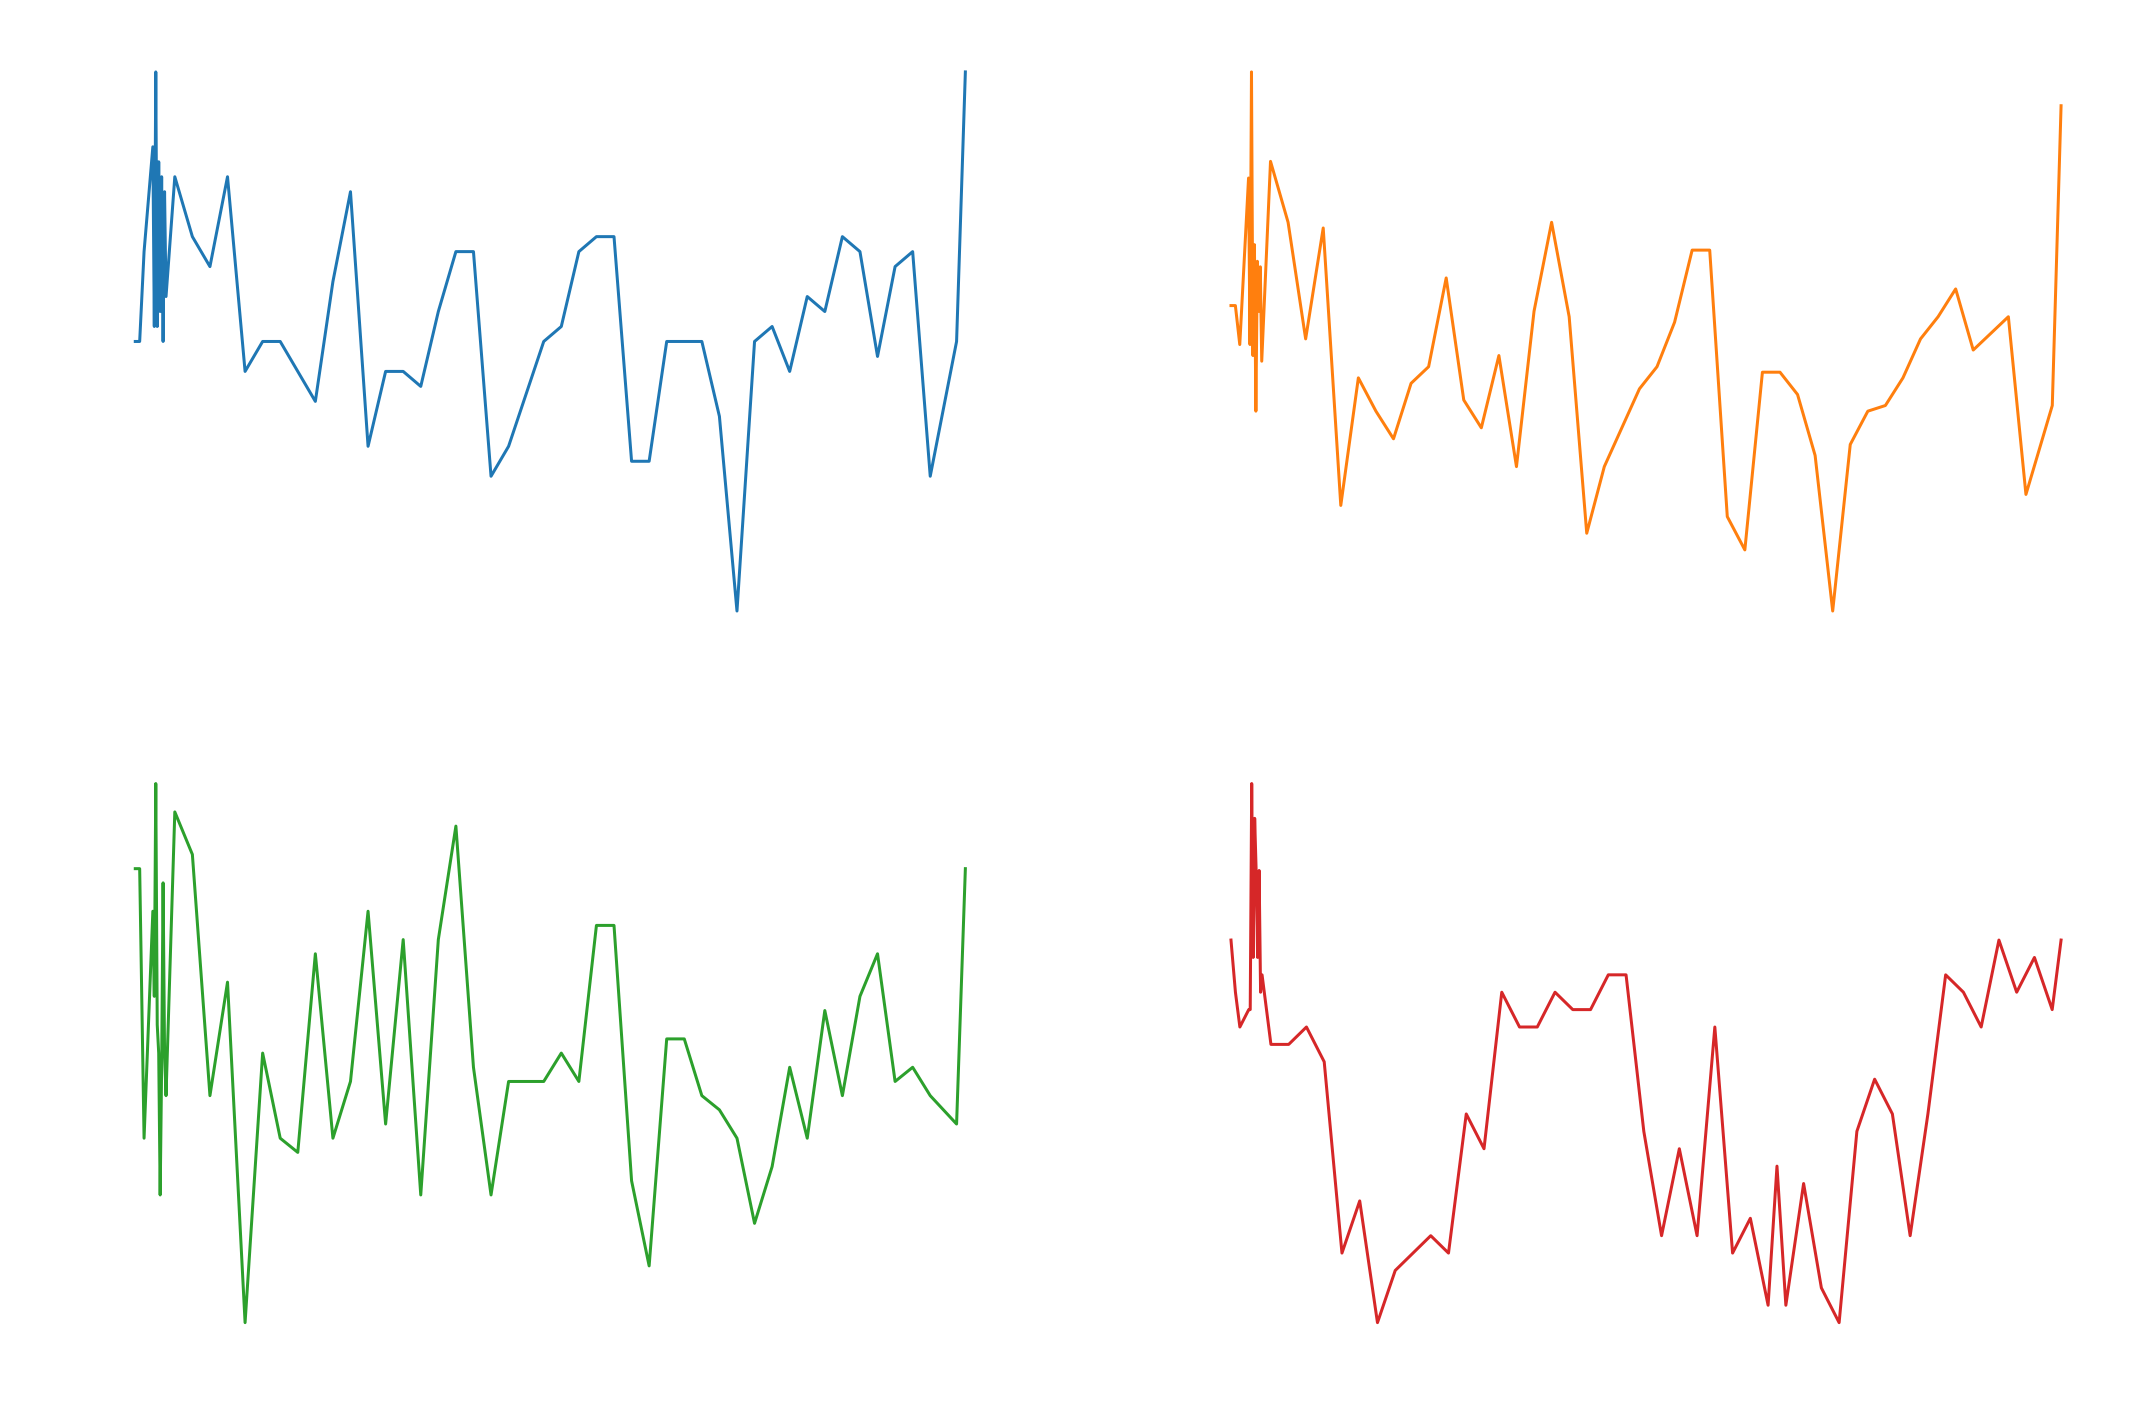

In [5]:
#subplots of time series features
%config InlineBackend.figure_format = 'retina'
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "text.color" : "w"}
plt.rcParams.update(params)
fig, axs = plt.subplots(2, 2, figsize = (18, 12))
fig.subplots_adjust(hspace=.2)
axs[0, 0].plot(NIDiasABP[0],NIDiasABP[2])
axs[0, 0].set_title('NIDiasABP')
axs[0, 1].plot(NIMAP[0],NIMAP[2], 'tab:orange')
axs[0, 1].set_title('NIMAP')
axs[1, 0].plot(NISysABP[0],NISysABP[2], 'tab:green')
axs[1, 0].set_title('NISysABP')
axs[1, 1].plot(HR[0],HR[2], 'tab:red')
axs[1, 1].set_title('HR')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Values')


# Using fbprophet for Anamoly Detection <br>
Also using Altair for interactive plot <br>
Credit Insaf Ashrapov https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f

In [6]:
#Anomaly Detection functions using prophet
def fit_predict_model(dataframe, interval_width = 0.95, changepoint_range = 1):
    m = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [7]:
#Interactive plot of anomalies using Altair 7FC97F 37B6CE
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#64A8D1').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=25, opacity=1, color = 'blue').encode(
        x='ds:T',
        y=alt.Y('fact', title='Values'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = '#ff0164').encode(
        x='ds:T',
        y=alt.Y('fact', title='Values'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20, color='white')\
              .configure_axis(labelColor='white',titleColor='white')

In [8]:
#Setting up features to plot
NIDiasABP = NIDiasABP.rename(columns={0:'ds',2:'y'})
NIMAP = NIMAP.rename(columns={0:'ds',2:'y'})
HR = HR.rename(columns={0:'ds',2:'y'})
Weight = Weight.rename(columns={0:'ds',2:'y'})

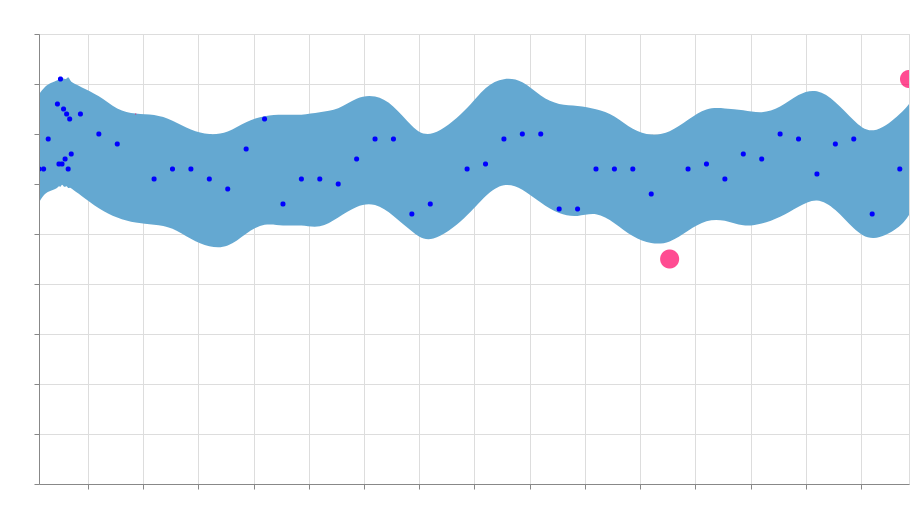

In [10]:
#Plot
pred = fit_predict_model(NIDiasABP)
pred = detect_anomalies(pred)
alt.renderers.enable('notebook')
plot_anomalies(pred)

### Found number of anomalies! Detect_Anomaly has a built in importance feature as well.
These will be the features that I extract from the time series data. My hypothesis is that a higher number of anomalies, as well as the severity of the anomalies, will be predictors for patient health. Importance is the percent error for a datapoint from the model's predicted value.

In [11]:
pred['anomaly'].astype(bool).sum()

3

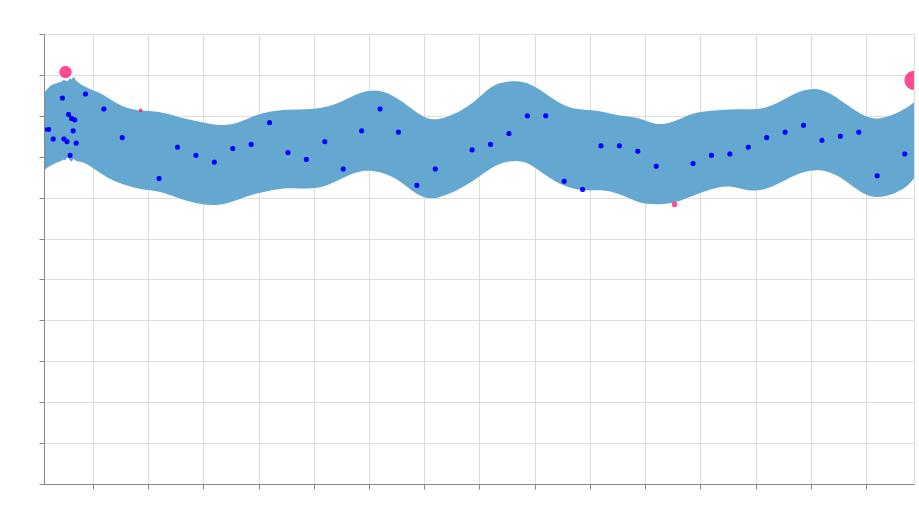

In [12]:
#Example with NIMAP
pred = fit_predict_model(NIMAP)
pred = detect_anomalies(pred)
alt.renderers.enable('notebook')
plot_anomalies(pred)

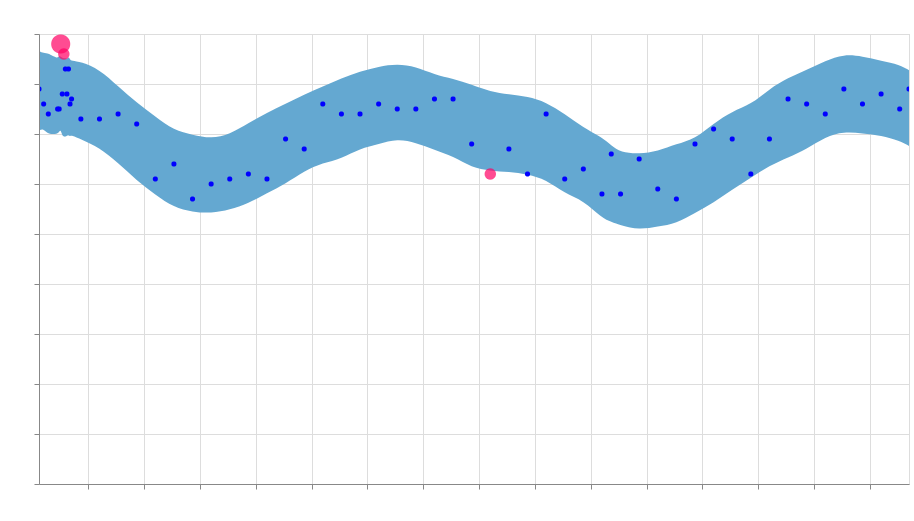

In [13]:
pred = fit_predict_model(HR)
pred = detect_anomalies(pred)
alt.renderers.enable('notebook')
plot_anomalies(pred)

## Anomaly Detection with SARIMA

In [14]:
import statsmodels.tsa.api as smt

In [15]:
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [16]:
HR2 = HR
HR2.index = HR2['ds']
HR2 = HR2.drop(columns = 'ds')

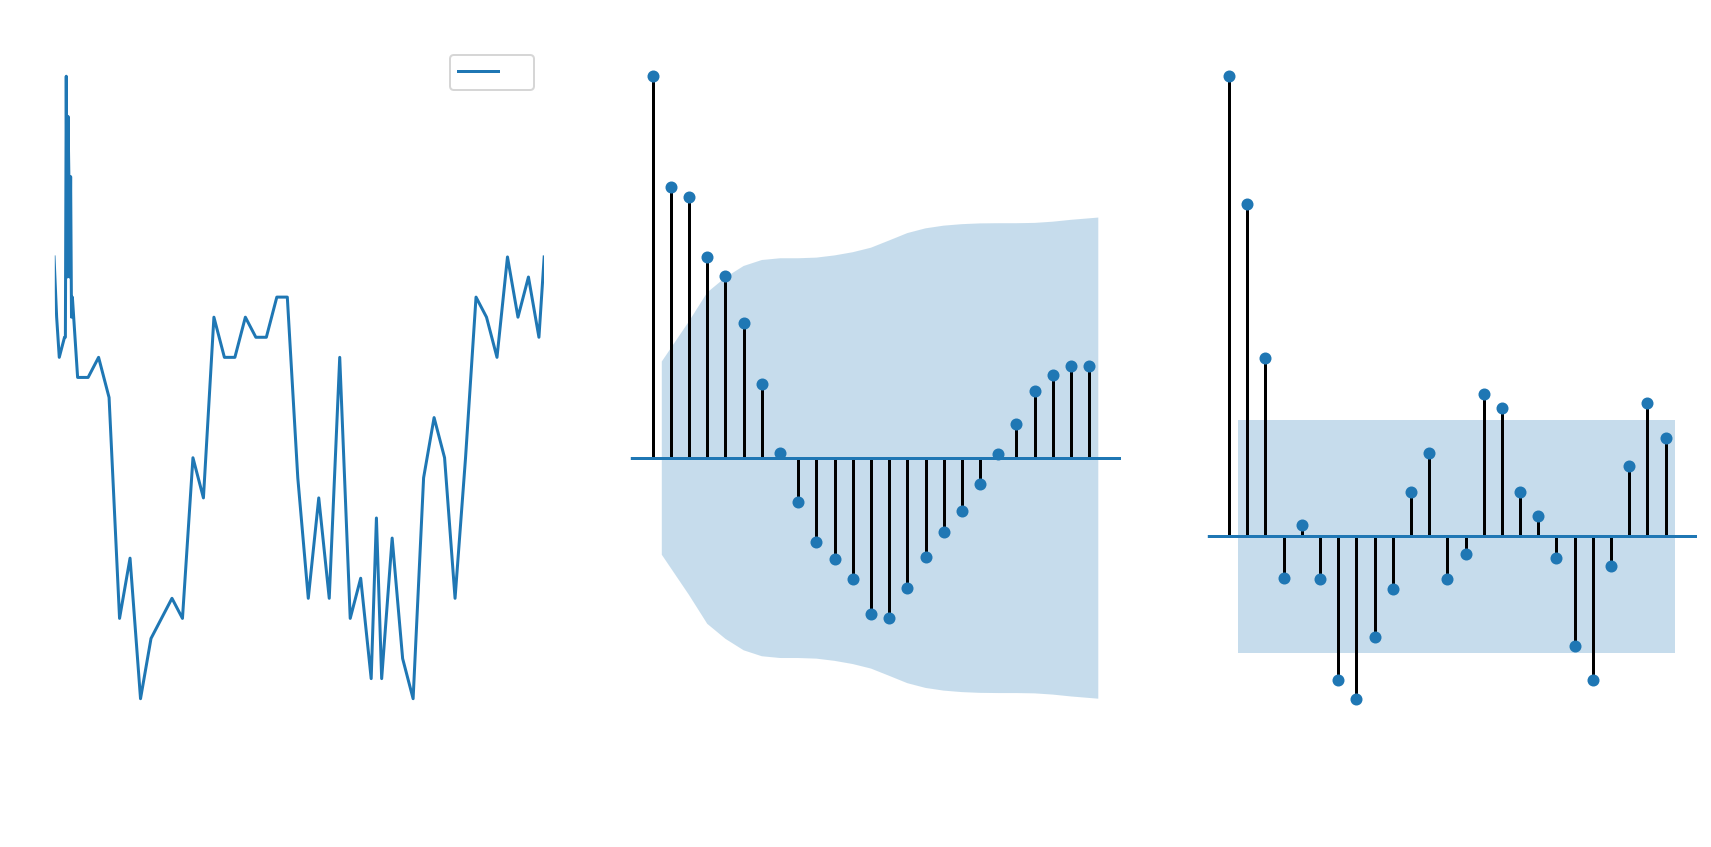

In [17]:
plots(HR2, lags=24);

Clear autocorrelation for Heart Rate

In [18]:
NIDiasABP2 = NIDiasABP
NIDiasABP2.index = NIDiasABP2['ds']
NIDiasABP2 = NIDiasABP2.drop(columns = 'ds')

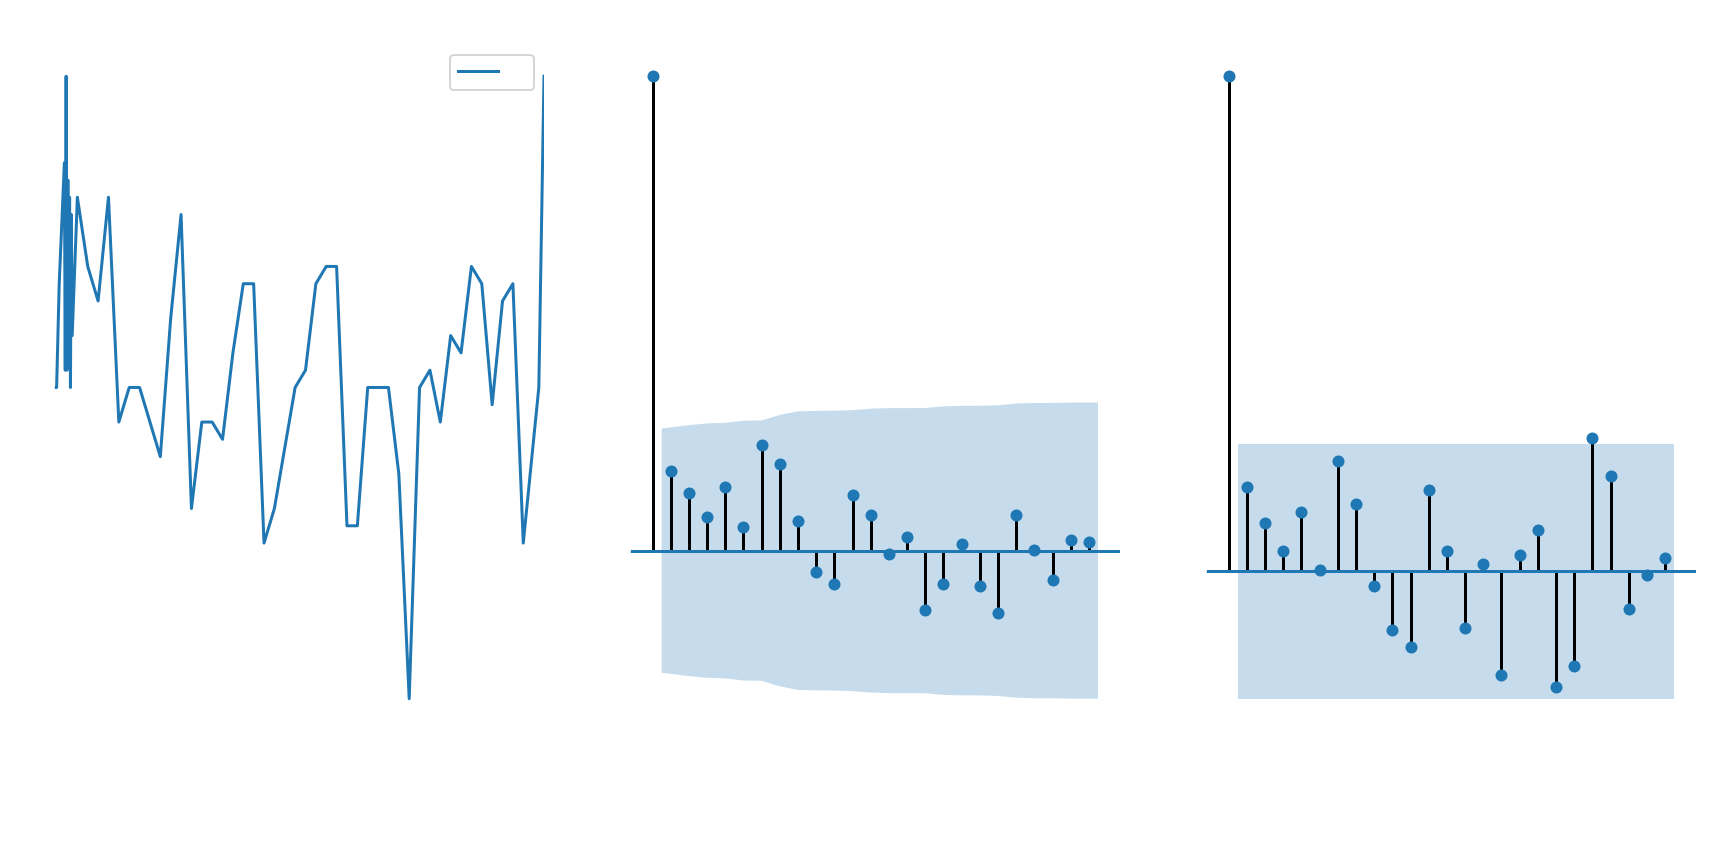

In [19]:
plots(NIDiasABP2, lags=24);

No clear autocorrelation for blood pressure. <br>
**Conclusion: after many hours crawling down this rabbit hole, SARIMA proves too difficult to use to find anomalies for all my time series data on sheer volume of data for my dataset, going to stick with prophet**

### Extract Time Series Features en Masse<br>
Reading in all time series data, running prophet, and creating num_anomalies and mean_importance features to add to my model. Please pardon my dust here, my code is crazy because I am formatting as I am reading in a giant block of data. I also uploaded this into AWS and ran this model on all of my data on AWS. 

In [7]:
#read in textfile as dataframe with time converted to minutes only (datetime )
with open("ICU_data/132543.txt") as f:
    content = f.readlines()
    contents = [i.rstrip().split(',') for i in content]
data = pd.DataFrame(contents).iloc[1:]

#changing time to datetime object, and all string values to floats
data[0] = pd.to_datetime(['1900-01-0'+str(int(int(row[:2])/24)+1)+' '
                          +str(int(int(row[:2])%24))+':'+row[3:5]+':00' for row in data[0]])
data[2] = [float(row) for row in data[2]]

In [9]:
from tqdm import tqdm
import glob
import errno
from collections import defaultdict

In [12]:
path = 'ICU_2ndGroup/*.txt'
files = glob.glob(path)
for name in files:
    try:
        with open(name) as f:
            pass # do what you want
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [13]:
total_importance = defaultdict(list)
total_anomaly = defaultdict(list)
importance = [-1]*9
anomaly_count = [-1]*9
names = ['NISysABP','NIDiasABP','NIMAP','SysABP','DiasABP','MAP','Temp','HR','Weight']

In [14]:
#Read in and compute a mountain of data! Use AWS for this later when I figure that shit out
with tqdm(total=100) as pbar:
    for file in sorted(files):
        with open(file) as f:
            content = f.readlines()
        contents = [i.rstrip().split(',') for i in content]
        data = pd.DataFrame(contents).iloc[1:]
        record = int(data[2][1])

        #changing time to datetime object, and all string values to floats
        data[0] = pd.to_datetime(['1900-01-0'+str(int(int(row[:2])/24)+1)+' '
                                  +str(int(int(row[:2])%24))+':'+row[3:5]+':00' for row in data[0]])
        data[2] = [float(row) for row in data[2]]

        #Run prophet model and store importance sums for each category in total_dict
        for index, name in enumerate(names):
            tseries = data[data[1] == name].drop(columns = 1).rename(columns={0:'ds',2:'y'})
            if tseries.empty or len(tseries)<10:
                importance[index] = -1
                anomaly_count[index] = -1
            else:
                pred = detect_anomalies(fit_predict_model(tseries))
                importance[index] = pred['importance'].mean()
                anomaly_count[index] = pred['anomaly'].astype(bool).sum()

        #Add the lists of values to the dictionaries
        total_importance[record] = importance.copy()
        total_anomaly[record] = anomaly_count.copy()

        pbar.update(.27)

  0%|          | 0/100 [00:00<?, ?it/s]INFO:fbprophet:n_changepoints greater than number of observations.Using 21.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
  1%|          | 0.54/100 [00:20<1:28:45, 53.54s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
  1%|          | 0.81/100 [00:48<1:52:11, 67.86s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 9.
INFO:fbprophet:n_chang

INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 12%|█▏        | 12.419999999999987/100 [13:23<1:10:41, 48.43s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
 13%|█▎        | 12.689999999999987/100 [13:35<1:09:31, 47.78s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 13%|█▎        | 13.229999999999986/100 [13:57<1:03:58, 44.24s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
 14%|█▍        | 13.769999999999985/100 [14:10<49:14, 34.26s/it]  INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
 14%|█▍        | 14.309999999999985/100 [14:25<43:10, 30.23s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
 15%|█▍        | 14.849999999999984/100 [14:53<58:10, 40.99s/it]

INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
 26%|██▌       | 26.189999999999966/100 [24:14<1:02:48, 51.06s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 26%|██▋       | 26.459999999999965/100 [24:31<1:07:07, 54.77s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
INFO:fbprophet:n_changepoints gr

INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
 38%|███▊      | 37.800000000000026/100 [33:19<42:27, 40.96s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
 39%|███▊      | 38.610000000000035/100 [34:00<47:46, 46.69s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 39%|███▉      | 38.88000000000004/100 [34:18<54:02, 53.06s/it] INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
 39%|███▉      | 39.15000000000004/100 [34:47<1:10:40, 69.68s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
INFO:fbprophet:n_changepoints greater than number of observ

INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
 49%|████▉     | 49.14000000000016/100 [43:49<46:46, 55.18s/it] INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 49%|████▉     | 49.41000000000016/100 [44:01<44:09, 52.38s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
 50%|████▉     | 49.950000000000166/100 [44:29<42:09, 50.54s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
 50%|█████     | 50.22000000000017/100 [44:37<36:25, 43.91s/it] INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
 51%|█████     | 50.760000000000176/100 [44:59<34:51, 42.47s/

INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
 66%|██████▌   | 65.61000000000031/100 [55:27<28:26, 49.63s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
 66%|██████▌   | 65.88000000000031/100 [55:39<27:18, 48.03s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
 66%|██████▌   | 66.1500000000003/100 [55:50<25:51, 45.82s/it] INFO:fbprophet:n_changepoints greater than number of observations.Using 10.
 66%|██████▋   | 66.4200000000003/100 [56:04<26:15, 46.92s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 9.
 67%|██████▋   | 66.6900000000003/100 [56:21<28:42, 51.72s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
 67%

 77%|███████▋  | 76.95000000000014/100 [1:04:35<19:20, 50.33s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
 77%|███████▋  | 77.22000000000014/100 [1:04:49<19:03, 50.20s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
 77%|███████▋  | 77.49000000000014/100 [1:04:57<16:42, 44.53s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
 78%|███████▊  | 78.03000000000013/100 [1:05:13<13:09, 35.95s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
 78%|███████▊  | 78.30000000000013/100 [1:05:29<15:50, 4

INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
 93%|█████████▎| 93.1499999999999/100 [1:18:11<05:23, 47.18s/it] INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 94%|█████████▍| 93.9599999999999/100 [1:19:02<05:42, 56.73s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
 94%|█████████▍| 94.22999999999989/100 [1:19:11<04:49, 50.24s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 12.
 94%|█████████▍| 94.49999999999989/100 [1:19:21<04:10, 45.48s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 14.
 95%|█████████▌| 95.03999999999988/100 [1:19:43<03:31, 42.74s/it]INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Us

In [15]:
total_imp = pd.DataFrame(total_importance).transpose()
total_ano = pd.DataFrame(total_anomaly).transpose()
total_imp = total_imp.rename(columns = 
                             {0:'NISysABP_I',1:'NIDiasABP_I',2:'NIMAP_I',3:'SysABP_I',
                              4:'DiasABP_I',5:'MAP_I',6:'Temp_I',7:'HR_I',8:'Weight_I'})
total_ano = total_ano.rename(columns = 
                             {0:'NISysABP_A',1:'NIDiasABP_A',2:'NIMAP_A',3:'SysABP_A',
                              4:'DiasABP_A',5:'MAP_A',6:'Temp_A',7:'HR_A',8:'Weight_A'})
all_importance_anomaly = pd.concat([total_imp, total_ano], axis=1, sort=False)

In [16]:
all_importance_anomaly.head()

,NISysABP_I,NIDiasABP_I,NIMAP_I,SysABP_I,DiasABP_I,MAP_I,Temp_I,HR_I,Weight_I,NISysABP_A,NIDiasABP_A,NIMAP_A,SysABP_A,DiasABP_A,MAP_A,Temp_A,HR_A,Weight_A
133038,0.000422,0.000000,0.001414,0.000300,0.00043,0.000000,0.000186,0.003269,-1.000000,1,0,1,1,1,0,1,3,-1
133039,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1,-1,-1,-1,-1,-1,-1,-1
133040,0.008257,0.038726,0.004941,0.001455,0.00200,0.002643,0.000009,0.000513,0.000778,2,1,1,4,6,10,1,6,8
133059,0.000489,0.000000,0.000135,-1.000000,-1.00000,-1.000000,-1.000000,0.000000,0.000000,1,0,1,-1,-1,-1,-1,0,0
133061,0.003304,0.007005,0.004934,-1.000000,-1.00000,-1.000000,0.000000,0.001716,0.000000,4,2,3,-1,-1,-1,0,3,0


In [17]:
pickle_out = open("all_importance_anomaly2","wb")
pickle.dump(all_importance_anomaly, pickle_out)
pickle_out.close()

In [18]:
all_importance_anomaly.tail()

,NISysABP_I,NIDiasABP_I,NIMAP_I,SysABP_I,DiasABP_I,MAP_I,Temp_I,HR_I,Weight_I,NISysABP_A,NIDiasABP_A,NIMAP_A,SysABP_A,DiasABP_A,MAP_A,Temp_A,HR_A,Weight_A
134003,0.002328,0.006765,0.003438,0.001517,0.001863,0.001509,0.000122,0.003148,0.000004,3,3,3,3,3,4,4,4,3
134007,-1.000000,-1.000000,-1.000000,0.001084,0.002198,0.002557,0.000000,0.000552,0.000235,-1,-1,-1,1,1,2,0,1,2
134008,-1.000000,-1.000000,-1.000000,0.000627,0.001579,0.001555,0.000010,0.000250,0.000174,-1,-1,-1,3,1,1,1,1,2
134009,0.000967,0.001789,0.003394,0.002082,0.002836,0.002106,0.000000,0.003531,0.000702,1,1,1,2,4,3,0,7,7
134010,0.001551,0.005449,0.001771,0.003587,0.001432,0.001922,0.000000,inf,0.000000,3,3,1,2,4,2,0,1,0
